## Deep Stocks

In [1]:
import numpy as np
import pandas as pd
import string, re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math
import talib

from keras.models import Sequential, Model
from keras.layers import LeakyReLU
from keras.callbacks import EarlyStopping
from keras.layers import Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation, Input,TimeDistributed,BatchNormalization
from keras.layers.embeddings import Embedding
import time

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, mean_squared_error,mean_absolute_error
from sklearn.metrics import f1_score, precision_score, confusion_matrix, recall_score, accuracy_score

%matplotlib inline
pd.core.common.is_list_like = pd.api.types.is_list_like
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


## 1. Stocks Data (OHLCV)

In [2]:
dfa=pd.read_csv('microsoft_num.csv')
#dfa=pd.read_csv('Apple_num.csv')
#dfa=pd.read_csv('Amazon_num.csv')
dfa.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2007-05-30,30.549999,31.129999,30.510000,31.110001,23.677864,57376800
1,2007-05-31,31.120001,31.160000,30.610001,30.690001,23.358200,85290500


In [3]:
dfa['DateTime']=pd.to_datetime(dfa['Date'])
del(dfa['Date'])
del(dfa['Close'])

dfa['month'] = dfa['DateTime'].apply(lambda x: x.month)
dfa['day'] = dfa['DateTime'].apply(lambda x: x.day)
dfa['Year']=dfa['DateTime'].apply(lambda x: x.year)

dfa=dfa.rename(columns={'Adj Close':'Close'})
#dfa.reset_index(inplace=True)
dfa.set_index('DateTime', inplace=True)
dfa=dfa[(dfa.index>='2007-01-01')&(dfa.index<'2018-11-01')]
print('Stocks data shape: ',dfa.shape)
dfa.head(3)

Stocks data shape:  (2879, 8)


,Open,High,Low,Close,Volume,month,day,Year
DateTime,,,,,,,,
2007-05-30,30.549999,31.129999,30.510000,23.677864,57376800,5,30,2007
2007-05-31,31.120001,31.160000,30.610001,23.358200,85290500,5,31,2007
2007-06-01,30.790001,30.900000,30.549999,23.282089,39469400,6,1,2007


In [157]:
# IsolationForest
#dfi=dfa.iloc[:int(len(dfa)*0.84),:]
dfi=dfa.copy(deep=True)
print(f'Training data shape {dfi.shape}')
from sklearn.ensemble import IsolationForest
clf = IsolationForest(n_estimators=50,max_samples=100, contamination = 0.09, random_state=42,
                     behaviour="new")
clf.fit(dfi)
# Predictions
y_pred = clf.predict(dfi)

unique, counts = np.unique(y_pred, return_counts=True)
print('Anomaly Count',np.asarray((unique, counts)).T)

Training data shape (2980, 8)
Anomaly Count [[  -1  269]
 [   1 2711]]


In [158]:
mask=pd.DataFrame(dfi[y_pred==-1])
a=mask.Volume
ab=pd.DataFrame(a)
ab=ab.rename(columns={'Volume':'Mask'})
print(ab.shape)
ab.head(2)

(269, 1)


,Mask
DateTime,
2007-02-01,26123100
2007-02-02,25850700


In [159]:
dfg=pd.merge(dfi,ab, how='left', on='DateTime')
dfg['color']= np.where(dfg.Mask.isnull()==True , "#e60000", "#1f77b4")
dfg.head(2)

,Open,High,Low,Close,Volume,month,day,Year,Mask,color
DateTime,,,,,,,,,,
2007-01-03,38.68,39.060001,38.049999,38.700001,12405100,1,3,2007,NaN,#e60000
2007-01-04,38.59,39.139999,38.259998,38.900002,6318400,1,4,2007,NaN,#e60000


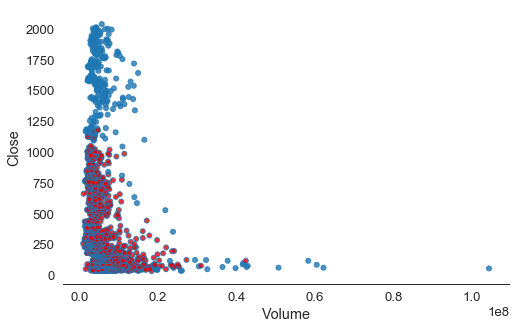

In [160]:
sns.set_style('white')
sns.set_context("paper", font_scale=1.5)  
a=plt.figure(figsize=(8,5))
sns.regplot(data=dfg, x="Volume", y="Close",
            fit_reg=False,
            scatter_kws={'facecolors':dfg['color'],"s": 25})
sns.despine(left=True)

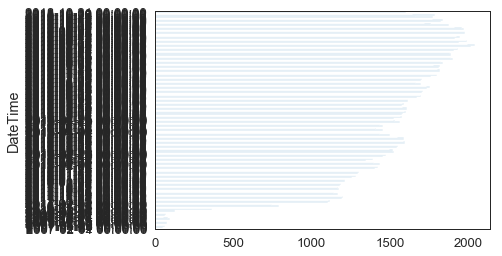

In [161]:
mask.Close.plot.barh(color='#1f77b4');

In [162]:
print(dfa.shape)
dfa=dfa[~dfa.isin(mask)].dropna()
print(dfa.shape)

(2980, 8)
(2711, 8)


### 2. Clustered Stocks

In [132]:
MSFT=['ADI', 'ADP', 'AMAT', 'AMGN', 'CELG', 'CERN', 'CHKP', 'CMCSA',
       'COST', 'CSCO', 'CTAS', 'EA', 'EBAY', 'ESRX', 'FAST', 'FISV',
       'FOX', 'FOXA', 'GILD', 'GOOG', 'GOOGL', 'HAS', 'HOLX', 'HSIC',
       'INTC', 'INTU', 'JBHT', 'KLAC', 'LBTYA', 'LBTYK', 'MAR', 'MCHP',
       'MDLZ', 'MSFT', 'MXIM', 'MYL', 'PAYX', 'PCAR', 'PEP', 'QCOM',
       'SBUX', 'SHPG', 'SNPS', 'SYMC', 'TXN', 'VOD', 'WBA', 'XLNX',
       'XRAY']
len(MSFT)

49

In [163]:
AAPL=['AAPL', 'ADBE', 'ADSK', 'ALXN', 'ASML', 'ATVI', 'BIIB', 'BMRN',
       'CDNS', 'CSX', 'CTSH', 'CTXS', 'DLTR', 'IDXX', 'ISRG', 'LRCX',
       'MNST', 'NTES', 'ORLY', 'ROST']
print(len(AAPL))

AMZN=['ALGN', 'AMZN', 'BIDU', 'BKNG', 'ILMN', 'INCY', 'MELI', 'NFLX',
       'NVDA', 'REGN', 'SWKS', 'ULTA']
print(len(AMZN))

20
12


In [164]:
#All Closing Prices
dfall=pd.read_csv('AllClose.csv')
dfall['Date']=pd.to_datetime(dfall['Date'])
dfall.rename(index=str, columns={"Date": "DateTime"},inplace=True)
dfall.set_index('DateTime', inplace=True)
print(dfall.shape)

(3163, 102)


In [134]:
# MICROSOFT
dfall=dfall.loc[:, dfall.columns.isin(MSFT)]
del(dfall['MSFT'])
print(dfall.shape)
dfall.head(2)

(3163, 48)


,ADI,ADP,AMAT,AMGN,CELG,CERN,CHKP,CMCSA,COST,CSCO,...,QCOM,SBUX,SHPG,SNPS,SYMC,TXN,VOD,WBA,XLNX,XRAY
DateTime,,,,,,,,,,,,,,,,,,,,,
2006-05-30,33.619999,35.957527,16.709999,66.830002,20.150,9.4375,19.120001,10.65,53.560001,19.77,...,44.720001,17.465000,43.889999,20.33,15.55,31.07,26.258919,40.200001,25.43,29.645
2006-05-31,33.730000,36.060623,16.910000,67.589996,20.725,9.4950,19.299999,10.71,52.930000,19.68,...,45.209999,17.825001,44.189999,20.43,15.60,31.23,26.794815,40.599998,26.00,29.900


In [69]:
# APPLE
dfall=dfall.loc[:, dfall.columns.isin(AAPL)]
del(dfall['AAPL'])
print(dfall.shape)
dfall.head(2)

(3163, 19)


,ADBE,ADSK,ALXN,ASML,ATVI,BIIB,BMRN,CDNS,CSX,CTSH,CTXS,DLTR,IDXX,ISRG,LRCX,MNST,NTES,ORLY,ROST
DateTime,,,,,,,,,,,,,,,,,,,
2006-05-30,28.350000,36.490002,8.0025,22.6350,6.285,45.270000,12.84,17.870001,11.033334,14.5275,29.757923,8.656667,18.8750,35.980000,43.500000,7.471250,21.070000,31.350000,6.8800
2006-05-31,28.629999,36.389999,8.1275,22.8825,6.540,46.630001,12.99,18.040001,11.153334,14.7500,29.925148,8.810000,19.1075,37.096668,44.790001,7.702917,20.450001,31.690001,7.0625


In [165]:
# AMAZON
dfall=dfall.loc[:, dfall.columns.isin(AMZN)]
del(dfall['AMZN'])
print(dfall.shape)
dfall.head(2)

(3163, 11)


,ALGN,BIDU,BKNG,ILMN,INCY,MELI,NFLX,NVDA,REGN,SWKS,ULTA
DateTime,,,,,,,,,,,
2006-05-30,7.37,7.766,31.01,13.700,4.07,NaN,3.928571,15.313334,11.56,5.61,NaN
2006-05-31,7.39,7.782,31.10,13.665,4.17,NaN,3.955714,15.320000,12.94,5.66,NaN


### 3. Sentiments

In [4]:
dfs=pd.read_csv('MSFT_Vader.csv')
#dfs=pd.read_csv('AAPL_Vade.csv')
#dfs=pd.read_csv('AMZN_Vade.csv')
dfs['DateTime']=pd.to_datetime(dfs['DateTime'],errors='coerce')
dfs['DateTime']=dfs.DateTime.dt.date
dfs['DateTime']=pd.to_datetime(dfs['DateTime'],errors='coerce')
dfs.set_index('DateTime', inplace=True)
print(dfs.shape)
dfs=dfs.groupby('DateTime').mean()
#dfs=dfs.groupby('DateTime').median()
print(dfs.shape)
dfs.head(2)

(174223, 4)
(3829, 4)


,negative,positive,neutral,compound
DateTime,,,,
2007-01-30,0.0,0.000,1.000,0.0000
2007-04-20,0.0,0.278,0.722,0.4019


### Merge DataFrames

In [167]:
print(f'OHLCV SHAPE {dfa.shape}, \nCluster Data Shape {dfall.shape},\nSentiments Data Shape{dfs.shape}')
print('\n')

df1=pd.merge(dfa,dfall,how='inner', on='DateTime')
df2=pd.merge(df1,dfs,how='inner', on='DateTime')
print(df2.shape)

OHLCV SHAPE (2711, 8), 
Cluster Data Shape (3163, 11),
Sentiments Data Shape(3052, 4)


(2098, 23)


### Technical Indicators

In [175]:
df=df2.copy(deep=True)
print('Original Data Shape',df2.shape)
df['3day MA'] = df['Close'].shift(1).rolling(window = 3).mean()
#df['10day MA'] = df['Close'].shift(1).rolling(window = 10).mean()
df['sma10'] = talib.SMA(df['Close'],timeperiod=10)
df['wma10'] = talib.WMA(df['Close'], timeperiod=10) #Weighted Moving Average
df['RSI'] = talib.RSI(df['Close'],timeperiod=10)
df['CCI'] = talib.CCI(df['High'], df['Low'], df['Close'], timeperiod=10)


#df['RSI'] = talib.RSI(df['Close'].values, timeperiod = 9)


df['Williams %R'] = talib.WILLR(df['High'].values, 
                                 df['Low'].values, df['Close'].values, 7)


df['MOM'] = talib.MOM(df['Close'], timeperiod=10) #Momentum
df['roc'] = talib.ROCP(df['Close'],timeperiod=10)

df['macd'],df['macdsignal'],df['macdhist'] = talib.MACD(df['Close'], fastperiod=10, slowperiod=16, 
                                                        signalperiod=9)#Moving Average Convergence/Divergence

df['ADOSC'] = talib.ADOSC(df['High'], df['Low'], df['Close'], df['Volume'], fastperiod=3, 
                          slowperiod=10) # Chaikin A/D Oscillator

df.dropna(inplace=True)
print('With Tech Indicators: ',df.shape)

Original Data Shape (2098, 23)
With Tech Indicators:  (2067, 35)


In [176]:
#df=df2.copy(deep=True)
#df['Return'] = df.Close
df['Return'] = df.Close.pct_change()
#df['Return']=df['Close']-(df['Close'].shift(1))
#df['Return']=np.log(df['Close']/(df['Close'].shift(1)))
del(df['Close'])
df.dropna(inplace=True)
df.head(2)

,Open,High,Low,Volume,month,day,Year,ALGN,BIDU,BKNG,...,RSI,CCI,Williams %R,MOM,roc,macd,macdsignal,macdhist,ADOSC,Return
DateTime,,,,,,,,,,,,,,,,,,,,,
2007-10-30,89.669998,90.650002,88.050003,5405400.0,10.0,30.0,2007.0,19.910000,37.099998,88.699997,...,60.262773,-88.235258,-93.374222,0.979996,0.011231,3.691697,5.451952,-1.760255,7.686166e+06,-0.019556
2007-10-31,88.050003,89.599998,87.000000,7044800.0,10.0,31.0,2007.0,20.700001,38.249001,93.099998,...,61.741653,-93.056861,-75.706187,-0.500000,-0.005577,3.240046,5.009571,-1.769525,7.674237e+06,0.010313


### Scaling

In [177]:
name=df.columns[:-1]
sc_x = MinMaxScaler(feature_range=(-1, 1))
#sc_x=StandardScaler()
x_scaled = sc_x.fit_transform(df.iloc[:,:-1])

sc_y = MinMaxScaler(feature_range=(-1, 1))
#sc_y=StandardScaler()
y_scaled = sc_y.fit_transform(df.iloc[:,-1].values.reshape(-1,1))

df = pd.DataFrame(x_scaled, columns=name)
df['Return']=y_scaled

df.head(2)

,Open,High,Low,Volume,month,day,Year,ALGN,BIDU,BKNG,...,RSI,CCI,Williams %R,MOM,roc,macd,macdsignal,macdhist,ADOSC,Return
0,-0.900908,-0.906176,-0.902389,-0.786614,0.636364,0.933333,-1.0,-0.884997,-0.796879,-0.957897,...,0.170643,-0.283599,-0.867484,-0.030915,-0.121963,0.073417,0.159031,-0.213437,0.192886,-0.501179
1,-0.903860,-0.908084,-0.904309,-0.707486,0.636364,1.000000,-1.0,-0.878701,-0.788120,-0.953447,...,0.211029,-0.298280,-0.514124,-0.040379,-0.163703,0.055543,0.135714,-0.214310,0.192349,-0.363562


## Single Feature Model Check

In [27]:
dataset=df['Return'].values
dataset=dataset.reshape(-1,1)

dataset = dataset.astype('float32')

np.random.seed(7)
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.84)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)


# reshape into X=t and Y=t+1
look_back = 20
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

from keras.callbacks import EarlyStopping
import time

# create and fit the LSTM network
model = Sequential() # New Instance of Model Object
model.add(LSTM(50, return_sequences=True, input_shape=(1, look_back)))
model.add(LSTM(72, return_sequences=True)) 
model.add(LSTM(82, return_sequences=True)) 
model.add(LSTM(42))
model.add(Dense(100, activation='relu'))
model.add(Dense(60, activation='relu'))
model.add(Dense(50, activation='relu'))
#model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='softmax'))
model.compile(loss='mean_squared_error', optimizer='ADAM')

start = time.time()
hist =model.fit(trainX, trainY, epochs=120, shuffle=False,batch_size=32, validation_data=(testX, testY), 
                callbacks=[EarlyStopping(monitor='val_loss', patience=30)], verbose=1)

end = time.time()
# Training Phase
model.summary()

2292 437
Train on 2271 samples, validate on 416 samples
Epoch 1/120
2271/2271 [==============================] - 2s 984us/step - loss: 0.1922 - val_loss: 0.1886
Epoch 2/120
2271/2271 [==============================] - 0s 135us/step - loss: 0.1922 - val_loss: 0.1886
Epoch 3/120
2271/2271 [==============================] - 0s 135us/step - loss: 0.1922 - val_loss: 0.1886
Epoch 4/120
2271/2271 [==============================] - 0s 135us/step - loss: 0.1922 - val_loss: 0.1886
Epoch 5/120
2271/2271 [==============================] - 0s 134us/step - loss: 0.1922 - val_loss: 0.1886
Epoch 6/120
2271/2271 [==============================] - 0s 134us/step - loss: 0.1922 - val_loss: 0.1886
Epoch 7/120
2271/2271 [==============================] - 0s 135us/step - loss: 0.1922 - val_loss: 0.1886
Epoch 8/120
2271/2271 [==============================] - 0s 135us/step - loss: 0.1922 - val_loss: 0.1886
Epoch 9/120
2271/2271 [==============================] - 0s 134us/step - loss: 0.1922 - val_loss: 0.1886

### XGB Feature Importance

In [ ]:
import xgboost as xgb
model = xgb.XGBRegressor(n_estimators=50)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Plot feature importance
fi = pd.DataFrame(index=X.columns, data=np.sort(model.feature_importances_))
fi.sort_values(by=0, ascending=False, inplace=True)
fi=fi[:20]
ax = fi.plot(kind="bar", figsize=(8, 4),width=0.4)
ax.set_ylabel("Importance Score")
ax.set_xlabel('Features for MSFT')
ax.legend_.remove()
sns.despine(left=True)
#plt.savefig('feat.png', bbox_inches='tight', dpi=350)

In [ ]:
a=np.percentile(model.feature_importances_,40)
print(a)
print(len(model.feature_importances_[model.feature_importances_>a]))

def selectKImportance(model, X, k=5):
     return X.iloc[:,model.feature_importances_.argsort()[::-1][:k]]
X=selectKImportance(model,X,k=35)

### AutoEncoder Features

In [ ]:
X=df.iloc[:,:]
split = int(len(df)*0.84)
X_train, X_test = X[:split], X[split:]

sc = MinMaxScaler(feature_range=(-1,1))
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
X_train.min(),X_train.max()

In [ ]:
from keras.layers import Input, Dense
from keras.models import Model
import tensorflow as tf

input_dim = X_train.shape[1]
feature_dim = [30, 24, 18, 12]
print('Input Dimensions',input_dim)
inputs = Input(shape=(input_dim,))
encoded = inputs
encoded = Dense(feature_dim[0], kernel_initializer="uniform")(encoded)
encoded = Dense(feature_dim[1], kernel_initializer="uniform")(encoded)
encoded = Dense(feature_dim[2], kernel_initializer="uniform")(encoded)
encoded = Dense(feature_dim[3], kernel_initializer="uniform")(encoded)

decoded = encoded
decoded = Dense(feature_dim[2], kernel_initializer="uniform")(decoded)
decoded = Dense(feature_dim[1], kernel_initializer="uniform")(decoded)
decoded = Dense(feature_dim[0], kernel_initializer="uniform")(decoded)
decoded = Dense(input_dim, kernel_initializer="uniform")(decoded)


autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(X_train, X_train,
                verbose=0,
                epochs=150,
                batch_size=32,
                shuffle=False,
                validation_data=(X_test, X_test))

predict_vals = autoencoder.predict(X_train)
print('Prediction Shape',predict_vals.shape)
plt.plot(predict_vals)
plt.show()

In [ ]:
from keras.models import Sequential

featuremodel = Sequential()
featuremodel.add(Dense(feature_dim[0], input_shape=(input_dim,),
                       weights=autoencoder.layers[1].get_weights()))

featuremodel.add(Dense(feature_dim[1], weights=autoencoder.layers[2].get_weights()))

featuremodel.add(Dense(feature_dim[2], weights=autoencoder.layers[3].get_weights()))

featuremodel.add(Dense(feature_dim[3], weights=autoencoder.layers[4].get_weights()))

featuremodel.compile(optimizer='adam', loss='mse')

In [ ]:
X1=featuremodel.predict(X)

In [ ]:
names=['feat1','feat2','feat3','feat4','feat5','feat6',
      'feat7','feat8','feat9','feat10','feat11','feat12']
df2=pd.DataFrame(X1, columns=names)
df2.index=X.index
df2['Return']=df.Return.values
df2.head()

### Multsequence Input Function for LSTM

In [178]:
# 3D Input and Shift Function on Return
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    print ("Amount of features = {}".format(amount_of_features))
    data = stock.as_matrix()
    sequence_length = seq_len + 1 # index starting from 0
    result = []

    for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
        result.append(data[index: index + sequence_length]) # index : index + 22days

    
    result = np.array(result)
   
        
    row = round(0.85 * result.shape[0]) # 85% split
    print ("Amount of training data = {}".format(round(0.86 * result.shape[0])))
    print ("Amount of testing data = {}".format(round(0.17 * result.shape[0])))
    
    
    train = result[:int(row), :] # 90% date
    
    X_train = train[:, :-1] # all data until day m
    y_train = train[:, -1][:,-1] # day m + 1 adjusted close price

    X_test = result[int(row):, :-1]
    
    #X_test = sc.transform(X_test)
    y_test = result[int(row):, -1][:,-1]


    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))

    return [X_train, y_train, X_test, y_test]

### Get Inputs

In [179]:
X_train, y_train, X_test, y_test = load_data(df,20)

Amount of features = 35
Amount of training data = 1759
Amount of testing data = 348


In [116]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(2224, 30, 69) (2224,) (392, 30, 69) (392,)


## Model 1. Vanilla

In [204]:
from numpy.random import seed
seed(40)
from tensorflow import set_random_seed
set_random_seed(50)

# create and fit the LSTM network
model = Sequential() # New Instance of Model Object
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))

model.add(Dense(32, activation='relu'))
model.add(LeakyReLU(alpha=0.001))
model.add(Dropout(0.02))

model.add(Dense(16, activation='relu'))
model.add(LeakyReLU(alpha=0.001))
model.add(Dropout(0.02))


model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='ADAM')

hist =model.fit(X_train, y_train, epochs=120, shuffle=False,batch_size=32, 
                validation_data=(X_test, y_test), 
                callbacks=[EarlyStopping(monitor='val_loss',mode='min',
                                         patience=35)],
                verbose=1)

# Training Phase
#model.summary()

Train on 1738 samples, validate on 307 samples
Epoch 1/120
1738/1738 [==============================] - 3s 1ms/step - loss: 0.0240 - val_loss: 0.0572
Epoch 2/120
1738/1738 [==============================] - 1s 290us/step - loss: 0.0216 - val_loss: 0.0299
Epoch 3/120
1738/1738 [==============================] - 1s 291us/step - loss: 0.0226 - val_loss: 0.0266
Epoch 4/120
1738/1738 [==============================] - 0s 284us/step - loss: 0.0196 - val_loss: 0.0225
Epoch 5/120
1738/1738 [==============================] - 0s 279us/step - loss: 0.0206 - val_loss: 0.0231
Epoch 6/120
1738/1738 [==============================] - 0s 267us/step - loss: 0.0202 - val_loss: 0.0282
Epoch 7/120
1738/1738 [==============================] - 0s 278us/step - loss: 0.0194 - val_loss: 0.0295
Epoch 8/120
1738/1738 [==============================] - 0s 274us/step - loss: 0.0183 - val_loss: 0.0331
Epoch 9/120
1738/1738 [==============================] - 0s 273us/step - loss: 0.0187 - val_loss: 0.0292
Epoch 10/1

## Model 2: CNN & LSTM

In [199]:
from numpy.random import seed
seed(40)
from tensorflow import set_random_seed
set_random_seed(50)

model = Sequential()
# add conv1D layer
model.add(Conv1D(filters=32, kernel_size=10, padding='same',
                 activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.02))
model.add(MaxPooling1D(pool_size=3, padding='valid'))

model.add(Conv1D(filters=64, kernel_size=10, padding='same',
                 activation='relu'))
model.add(Dropout(0.01))
model.add(MaxPooling1D(pool_size=3, padding='valid'))


#model.add(LSTM(50, dropout=0.2, recurrent_dropout=0.2))

model.add(LSTM(units=50))
model.add(LeakyReLU(alpha=0.001))
model.add(Dropout(0.02))
          
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(Dense(32, activation='relu'))
#model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.001))
model.add(Dropout(0.02))


#model.add(Flatten())
model.add(Dense(16, activation='relu'))
#model.add(BatchNormalization())
#model.add(LeakyReLU(alpha=0.001))
model.add(Dropout(0.01))


model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='ADAM')

start = time.time()
hist =model.fit(X_train, y_train, epochs=150, shuffle=False,batch_size=32, 
                validation_data=(X_test, y_test), 
                callbacks=[EarlyStopping(monitor='val_loss', mode='min',
                                         patience=35)], verbose=1)

Train on 1738 samples, validate on 307 samples
Epoch 1/150
1738/1738 [==============================] - 3s 1ms/step - loss: 0.0287 - val_loss: 0.0275
Epoch 2/150
1738/1738 [==============================] - 0s 225us/step - loss: 0.0181 - val_loss: 0.0222
Epoch 3/150
1738/1738 [==============================] - 0s 209us/step - loss: 0.0178 - val_loss: 0.0208
Epoch 4/150
1738/1738 [==============================] - 0s 211us/step - loss: 0.0178 - val_loss: 0.0184
Epoch 5/150
1738/1738 [==============================] - 0s 216us/step - loss: 0.0187 - val_loss: 0.0193
Epoch 6/150
1738/1738 [==============================] - 0s 209us/step - loss: 0.0181 - val_loss: 0.0164
Epoch 7/150
1738/1738 [==============================] - 0s 214us/step - loss: 0.0174 - val_loss: 0.0171
Epoch 8/150
1738/1738 [==============================] - 0s 224us/step - loss: 0.0177 - val_loss: 0.0164
Epoch 9/150
1738/1738 [==============================] - 0s 223us/step - loss: 0.0171 - val_loss: 0.0170
Epoch 10/1

## Model 3: CNN & Stacked LSTM

In [28]:
from numpy.random import seed
seed(40)
from tensorflow import set_random_seed
set_random_seed(50)

model = Sequential()

# add conv1D layer
model.add(Conv1D(filters=64,kernel_size=3, padding='same',
                 activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.02))
#model.add(MaxPooling1D(pool_size=3))

model.add(Conv1D(filters=64, kernel_size=3, padding='same',
                 activation='relu'))
model.add(Dropout(0.02))
model.add(MaxPooling1D(pool_size=3))


#model.add(LSTM(50, dropout=0.2, recurrent_dropout=0.2))

model.add(LSTM(units = 60, return_sequences = True))          
model.add(LeakyReLU(alpha=0.001))
model.add(Dropout(0.01))
          
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 40,return_sequences = False))
model.add(LeakyReLU(alpha=0.001))
model.add(Dropout(0.02))


model.add(Dense(64))
#model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.001))
model.add(Dropout(0.03))

model.add(Dense(32))
#model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.001))
model.add(Dropout(0.03))


model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='ADAM')

hist =model.fit(X_train, y_train, epochs=150, shuffle=False,batch_size=32,
                validation_data=(X_test, y_test), 
                callbacks=[EarlyStopping(monitor='val_loss', mode='min',
                                         patience=30)], verbose=1)

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
Train on 2362 samples, validate on 417 samples
Epoch 1/150
2362/2362 [==============================] - 2s 922us/step - loss: 0.0185 - val_loss: 0.0064
Epoch 2/150
2362/2362 [==============================] - 1s 348us/step - loss: 0.0181 - val_loss: 0.0065
Epoch 3/150
2362/2362 [==============================] - 1s 366us/step - loss: 0.0177 - val_loss: 0.0064
Epoch 4/150
2362/2362 [==============================] - 1s 348us/step - loss: 0.0176 - val_loss: 0.0064
Epoch 5/150
2362/2362 [==============================] - 1s 343us/step - loss: 0.0174 - val_loss: 0.0064
Epoch 6/150
2362/2362 [==============================] - 1s 352us/step - loss: 0.0176 - val_loss: 0.0068
Epoch 7/150
2362/2362 [==============================] - 1s 346us/step - loss: 0.0176 - val_loss: 0.0068
Epoch 8/150
2362/2362 [==============================] - 1s 346us/step - loss: 0.0176 - val_loss: 0.0067
Epoch 9/150
2362/2362 [=======

## Predictions

In [205]:
# Make predictions
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

# invert predictions
trainPredict1 = sc_y.inverse_transform(trainPredict)
y_train1 = sc_y.inverse_transform([y_train])
testPredict1 = sc_y.inverse_transform(testPredict)
y_test1 = sc_y.inverse_transform([y_test])

#Reshape
y_train1=y_train1.reshape(-1,1)
trainPredict1=trainPredict1.reshape(-1,1)
y_test1=y_test1.reshape(-1,1)
testPredict1=testPredict1.reshape(-1,1)

print(trainPredict1.min(),trainPredict1.max(),trainPredict1.mean())
print(testPredict1.min(),testPredict1.max(),testPredict1.mean())

-0.058609948 0.11641778 -0.0021253556
-0.011422674 0.183872 0.04197288


In [206]:
print('\t---PERFORMANCE---\n')
print('Mean Absolute Error Train:', mean_absolute_error(y_train1, trainPredict1))
print('Mean Absolute Error Test:', mean_absolute_error(y_test1, testPredict1))

print('\nMean Squared Error Train:',(mean_squared_error(y_train1, trainPredict1)))
print('Mean Squared Error Test:',(mean_squared_error(y_test1, testPredict1)))

print('\nRoot Mean Squared Error Train:',np.sqrt(mean_squared_error(y_train1, trainPredict1)))
print('Root Mean Squared Error Test:',np.sqrt(mean_squared_error(y_test1, testPredict1)))

act1 = np.where(y_train1>0.0,1,0)
pre1= np.where(trainPredict1>0,1,0)
print('\n Train Accuracy: ',accuracy_score(act1, pre1))

act = np.where(y_test1>0.0,1,0)
pre= np.where(testPredict1>0,1,0)
print('\n Test Accuracy: ',accuracy_score(act, pre))


print('\nPrecision: ', precision_score(act, pre,average='binary'))
print('\nRecall: ', recall_score(act, pre,average='binary'))

a=y_test
b=testPredict[:,0]
c=y_train
d=trainPredict[:,0]

def mape(ypred, ytrue):
    """ returns the mean absolute percentage error """
    idx = ytrue != 0.0
    return 100*np.mean(np.abs(ypred[idx]-ytrue[idx])/ytrue[idx])

print('\nMean Absolute % Error Train',mape(d,c))
print('Mean Absolute % Error Test',mape(testPredict[:,0], y_test))

print('mean absolute error \t mean absolute percentage error')
print(' %.9f \t\t\t %.9f' % (mean_absolute_error(y_test, testPredict[:,0]),
                             (np.mean(np.abs((y_test -  testPredict[:,0]) / (y_test+0.01))) * 100)))

	---PERFORMANCE---

Mean Absolute Error Train: 0.01826766663746575
Mean Absolute Error Test: 0.04612714931158859

Mean Squared Error Train: 0.000746783800462124
Mean Squared Error Test: 0.004216874892933763

Root Mean Squared Error Train: 0.027327345287497723
Root Mean Squared Error Test: 0.06493746909861643

 Train Accuracy:  0.5126582278481012

 Test Accuracy:  0.5342019543973942

Precision:  0.5514705882352942

Recall:  0.8771929824561403

Mean Absolute % Error Train -19.693254797937794
Mean Absolute % Error Test -50.64254265103047
mean absolute error 	 mean absolute percentage error
 0.212528518 			 59.772633894


In [ ]:
sns.set_style('white')
sns.set_context('paper', font_scale=1.3)
ax=plt.plot(y_test,linewidth=0.8)
p25=np.percentile(y_test,25)
p75=np.percentile(y_test,75)
plt.axhline(y=p25, color='r', linestyle='--',linewidth=1)
plt.axhline(y=p75, color='r', linestyle='--',linewidth=1)
sns.despine(left=1)
#ax=sns.boxplot(y_test,orient="v",saturation=0.55)
#ax = sns.swarmplot(y_test,color=".25", size=4, orient="v")

In [ ]:
high=y_test[y_test>=p75]
mod_high=y_test[(y_test<p75)&(y_test>0)]

low=y_test[y_test<=p25]
mod_low=y_test[(y_test>p25)&(y_test<=0)]

print(len(y_test),len(high),len(mod_high),len(low),len(mod_low))
a=[len(high),len(mod_high),len(low),len(mod_low),]
sum(a)

In [ ]:
y_test1=pd.DataFrame({'act':y_test})
conditions=[y_test1['act']>=p75,(y_test1['act']<p75)&(y_test1['act']>0),
            y_test1['act']<=p25, (y_test1['act']>p25)&(y_test1['act']<=0)]
choices     = [ "High", 'Mod_High', 'Low','Slight_Low' ]

y_test1['classa'] = np.select(conditions, choices)

In [ ]:
testPredict1=pd.DataFrame({'pre':testPredict[:,0]})
conditions=[testPredict1['pre']>=p75,(testPredict1['pre']<p75)&(testPredict1['pre']>0),
            testPredict1['pre']<=p25, (testPredict1['pre']>p25)&(testPredict1['pre']<=0)]
choices = [ "High", 'Mod_High', 'Low','Slight_Low' ]

testPredict1['classp'] = np.select(conditions, choices)

In [ ]:
print('\nAccuracy: ',accuracy_score(y_test1.classa.values, testPredict1.classp.values))

print('\nPrecision: ', precision_score(y_test1.classa.values, testPredict1.classp.values,average='macro'))
print('\nRecall: ', recall_score(y_test1.classa.values, testPredict1.classp.values,average='macro'))

## Model 4: CNN Stacked Bi-Directional LSTMs

In [84]:
from numpy.random import seed
seed(40)
from tensorflow import set_random_seed
set_random_seed(50)

model = Sequential()

# add conv1D layer
model.add(Conv1D(filters=16, kernel_size=3, padding='valid',
                 activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.03))
#model.add(MaxPooling1D(pool_size=3))

model.add(Conv1D(filters=32, kernel_size=3, padding='valid',
                 activation='relu'))
model.add(Dropout(0.03))
model.add(MaxPooling1D(pool_size=4))


model.add(Bidirectional(LSTM(40, return_sequences = True),merge_mode='concat'))
model.add(LeakyReLU(alpha=0.001))
model.add(Dropout(0.04))

model.add(Bidirectional(LSTM(20, return_sequences = False),merge_mode='concat'))
model.add(LeakyReLU(alpha=0.001))
model.add(Dropout(0.03))

model.add(Dense(32, activation='relu'))
#model.add(BatchNormalization())
#model.add(LeakyReLU(alpha=0.001))
model.add(Dropout(0.03))

model.add(Dense(16, activation='relu'))
#model.add(BatchNormalization())
model.add(Dropout(0.03))

model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='ADAM')

hist =model.fit(X_train, y_train, epochs=120, shuffle=True,batch_size=32, 
                validation_data=(X_test, y_test), 
                callbacks=[EarlyStopping(monitor='val_loss', patience=25)], verbose=1)

Train on 2158 samples, validate on 381 samples
Epoch 1/120
2158/2158 [==============================] - 3s 2ms/step - loss: 0.0204 - val_loss: 0.0077
Epoch 2/120
2158/2158 [==============================] - 1s 319us/step - loss: 0.0198 - val_loss: 0.0077
Epoch 3/120
2158/2158 [==============================] - 1s 317us/step - loss: 0.0197 - val_loss: 0.0077
Epoch 4/120
2158/2158 [==============================] - 1s 345us/step - loss: 0.0197 - val_loss: 0.0077
Epoch 5/120
2158/2158 [==============================] - 1s 331us/step - loss: 0.0198 - val_loss: 0.0077
Epoch 6/120
2158/2158 [==============================] - 1s 308us/step - loss: 0.0198 - val_loss: 0.0078
Epoch 7/120
2158/2158 [==============================] - 1s 307us/step - loss: 0.0196 - val_loss: 0.0076
Epoch 8/120
2158/2158 [==============================] - 1s 323us/step - loss: 0.0196 - val_loss: 0.0076
Epoch 9/120
2158/2158 [==============================] - 1s 313us/step - loss: 0.0197 - val_loss: 0.0076
Epoch 10/1

Epoch 78/120
2158/2158 [==============================] - 1s 314us/step - loss: 0.0195 - val_loss: 0.0076
Epoch 79/120
2158/2158 [==============================] - 1s 308us/step - loss: 0.0195 - val_loss: 0.0075
Epoch 80/120
2158/2158 [==============================] - 1s 302us/step - loss: 0.0195 - val_loss: 0.0076
Epoch 81/120
2158/2158 [==============================] - 1s 307us/step - loss: 0.0195 - val_loss: 0.0076
Epoch 82/120
2158/2158 [==============================] - 1s 305us/step - loss: 0.0195 - val_loss: 0.0077


In [ ]:
import matplotlib.pyplot as plt

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
loss_values50 = loss_values[0:150]
val_loss_values50 = val_loss_values[0:150]
epochs = range(1, len(loss_values50) + 1)
plt.plot(epochs, loss_values50, 'b',color = 'blue', label='Training loss')
plt.plot(epochs, val_loss_values50, 'b',color='red', label='Validation loss')
plt.rc('font', size = 10)
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(epochs)
#fig = plt.gcf()
fig.set_size_inches(10,4)
#fig.savefig('img/25/mrftest&validationlosscnn.png', dpi=300)
plt.show()

In [ ]:
mae = history_dict['mean_absolute_error']
vmae = history_dict['val_mean_absolute_error']
epochs = range(1, len(mae) + 1)
plt.plot(epochs, mae, 'b',color = 'blue', label='Training error')
plt.plot(epochs, vmae, 'b',color='red', label='Validation error')
plt.title('Training and validation error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.xticks(epochs)
fig = plt.gcf()
fig.set_size_inches(8,4)
#fig.savefig('img/25/mrftest&validationerrorcnn.png', dpi=300)
plt.show()

In [ ]:
'''trainScore = model.evaluate(X_train, y_train, verbose=0)
testScore = model.evaluate(X_test, y_test, verbose=0)
#predicting values for y_test
p = model.predict(x_test)

plt.plot(p,color='red', label='prediction')
plt.plot(y_test,color='blue', label='y_test')
plt.xlabel('No. of Trading Days')
plt.ylabel('Close Value (scaled)')
plt.legend(loc='upper left')
fig = plt.gcf()
fig.set_size_inches(10, 4)
#fig.savefig('img/25/mrftestcnn.png', dpi=300)
plt.show()'''

### RMSE

In [ ]:
df4=pd.read_excel('line_deep.xlsx', sheet_name='RMSE')
sns.set_style('white')
sns.set_context("paper", font_scale=1.3)  

with pd.plot_params.use('x_compat', True):
    #ax.set_xticks(df4.index)
    df4.MSFT.plot(color='#005ce6',linewidth=1.5, marker='s',markersize=5)
    df4.AAPL.plot(color='#808080',linewidth=1.5, marker='o',markersize=5)
    df4.AMZN.plot(color='#b30000',linewidth=1.5, marker='d',markersize=5)

plt.box(False)
plt.xticks([0,1, 2, 3], ['Vanilla\n LSTM', 'CNN-LSTM', 'CNN-\nStacked LSTM', 'CNN-\n Bi-Stacked LSTM'])
#plt.margins(0.2)
plt.xlabel('Model Type',labelpad=15)
plt.ylabel('Validation RMSE')
plt.legend(loc='upper right',frameon=False);
plt.tight_layout()
#plt.savefig('RMSE.png', bbox_inches='tight',dpi=300)

### MAE

In [ ]:
df4=pd.read_excel('line_deep.xlsx', sheet_name='MAE')
sns.set_style('white')
sns.set_context("paper", font_scale=1.3)  

with pd.plot_params.use('x_compat', True):
    #ax.set_xticks(df4.index)
    df4.MSFT.plot(color='#005ce6',linewidth=1.5, marker='s',markersize=5)
    df4.AAPL.plot(color='#808080',linewidth=1.5, marker='o',markersize=5)
    df4.AMZN.plot(color='#b30000',linewidth=1.5, marker='d',markersize=5)

plt.box(False)
plt.xticks([0,1, 2, 3], ['Vanilla\n LSTM', 'CNN-LSTM', 'CNN-\nStacked LSTM', 'CNN-\n Bi-Stacked LSTM'])
#plt.margins(0.2)
plt.xlabel('Model Type',labelpad=15)
plt.ylabel('Validation MAE')
plt.legend(loc='upper right',frameon=False);
plt.tight_layout()
#plt.savefig('MAE.png', bbox_inches='tight',dpi=300)

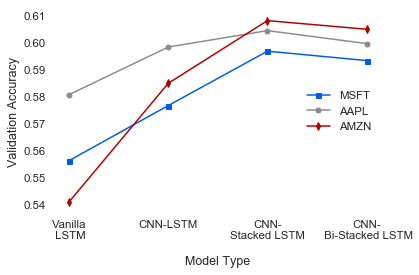

In [58]:
df5=pd.read_excel('line_deep.xlsx', sheet_name='Acc')

sns.set_style('white')
sns.set_context("paper", font_scale=1.3)  

with pd.plot_params.use('x_compat', True):
    #ax.set_xticks(df4.index)
    df5.MSFT.plot(color='#005ce6',linewidth=1.5, marker='s',markersize=5)
    df5.AAPL.plot(color='#8c8c8c',linewidth=1.5, marker='o',markersize=5)
    df5.AMZN.plot(color='#b30000',linewidth=1.5, marker='d',markersize=5)

plt.box(False)
plt.xticks([0,1, 2, 3], ['Vanilla\n LSTM', 'CNN-LSTM', 'CNN-\nStacked LSTM', 'CNN-\n Bi-Stacked LSTM'])
#plt.margins(0.2)
plt.xlabel('Model Type',labelpad=15)
plt.ylabel('Validation Accuracy')
plt.legend(loc='center right',frameon=False);
plt.tight_layout()
plt.savefig('Acc.png', bbox_inches='tight',dpi=300)

## Curve

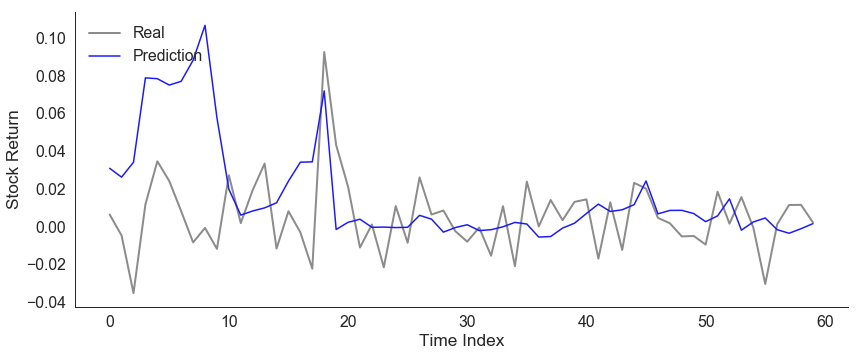

In [233]:
sns.set_style('white')
sns.set_context("paper", font_scale=1.8)  
plt.figure(figsize=(12,5))
ax = plt.subplot(111)
#ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

plt.plot(y_test1[170:230], linewidth=2, color='#8c8c8c', label = "Real")
plt.plot(testPredict1[170:230], linewidth=1.5, color='#1a1aff', label = "Prediction")

plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
#plt.subplots_adjust(left=0.07)
plt.xlabel('Time Index')
plt.ylabel('Stock Return')
plt.legend(loc='upper left',frameon=False);
plt.savefig('aapl.png', bbox_inches='tight',dpi=300)

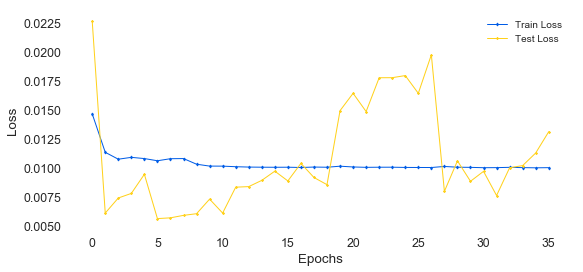

In [26]:
sns.set_style('white')
sns.set_context("paper", font_scale=1.4)  
plt.figure(figsize=(9,4))
import matplotlib as mpl
#mpl.rcParams['legend.frameon'] = 'True'
plt.plot(hist.history['loss'], color='#005ce6', linewidth=1, marker='d', markersize=2, label='Train Loss')
plt.plot(hist.history['val_loss'], color='#ffd11a',linewidth=1, marker='*',markersize=2, label='Test Loss')
plt.tick_params(left=False, labelleft=True) #remove ticks
plt.box(False)
plt.xlabel('Epochs')
plt.ylabel('Loss')
legend = plt.legend(loc='upper right',prop={'size': 10}, frameon=0)
#legend.get_frame().set_facecolor('#8c8c8c')

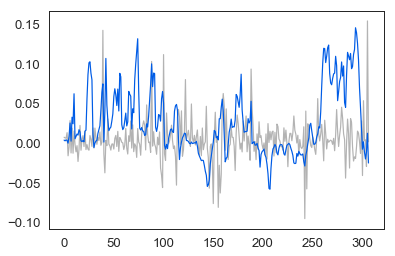

In [184]:
# plot baseline and predictions
ax = plt.subplot(111)
#ax.plot(dfa[['Adj Close']])
ax.plot(y_test1,color='#b3b3b3')
ax.plot(testPredict1,color='#005ce6')

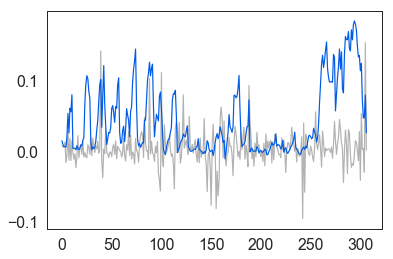

In [207]:
# plot baseline and predictions
ax = plt.subplot(111)
#ax.plot(dfa[['Adj Close']])
ax.plot(y_test1,color='#b3b3b3')
ax.plot(testPredict1,color='#005ce6')

In [234]:
from keras.models import save_model,load_model

In [235]:
model.save('aapl.hdf5')